## Modelo Predição valor de ação na Ambev

Período treinamento: 04 de jan. de 2016 - 13 de abr. de 2021 - Arquivo **ABEV3.SA.TRAINING.csv** - Filtro: 01/01/2016 ~ 04/14/2021

Período Validação: 14 de abr. de 2021 - 14 de mai. de 2021 - Arquivo **ABEV3.SA.TEST.csv**

Ambos dataset possuem informações dispostas em colunas:

* **Date**:  Data das operações na bolsa (diária)
* **Close**:  Valor de Fechamento do Índice da Ibovespa (no dia)
* **Open**:  Valor da Abertura do Índice da Ibovespa (no dia)
* **High**:  Valor máximo do Índice da Ibovespa (no dia)
* **Low**:  Valor mínimo do Índice da Ibovespa (no dia)
* **Vol**:  Volume de contratos negociados (no dia)

Será apenas considerada a coluna **"Open"**, que indica o valor de abertuda de cada dia.

### Bibliotecas

In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Carregando os dados


In [2]:
DataSetting = {
    'test': 'ABEV3.SA.TEST.csv',
    'training': 'ABEV3.SA.csv',
}

ModelSetting = {
    'recursions': 6,
    'epochs': 200,
    'batch_size': 32
}

In [3]:
### Agora vamos ler o arquivo do período desejável 
DataSet=pd.read_csv(DataSetting['training'])
DataSet=DataSet.dropna()
DataSet.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,17.730000,17.730000,17.209999,17.209999,14.775685,13206900.0
1,2016-01-05,17.250000,17.520000,17.110001,17.480000,15.007494,10774200.0
2,2016-01-06,17.360001,17.480000,17.200001,17.309999,14.861542,7739100.0
3,2016-01-07,17.170000,17.320000,16.850000,16.850000,14.466608,15316400.0
4,2016-01-08,16.930000,17.200001,16.930000,17.070000,14.655489,10684000.0


In [4]:
DataSet.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1.309000e+03
mean,17.792697,17.998083,17.587907,17.790321,16.392953,1.899838e+07
std,2.635976,2.608248,2.659921,2.645725,2.187032,1.243435e+07
min,10.730000,11.210000,10.360000,11.030000,10.694901,0.000000e+00
25%,16.400000,16.620001,16.120001,16.379999,15.258595,1.133310e+07
50%,18.190001,18.370001,18.000000,18.190001,16.522043,1.603210e+07
75%,19.240000,19.420000,19.070000,19.260000,17.592133,2.308080e+07
max,24.389999,24.559999,24.030001,24.270000,22.276297,1.440625e+08


### Inicialmente iremos criar uma RNN baseada apenas no Valor de Abertura

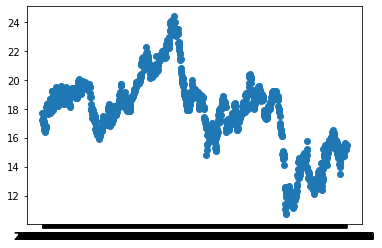

In [5]:
plt.scatter(DataSet['Date'], DataSet['Open'])
plt.show()

In [6]:
# Extrai apenas a coluna "Open"
base_treinamento = DataSet.iloc[:, 1:2].values

### Normalizar os dados de treinamento

Sera feito a normalização entre 0 e 1

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
DataScaled=scaler.fit_transform(base_treinamento)

In [8]:
print(DataScaled)

[[0.51244513]
 [0.47730604]
 [0.48535882]
 ...
 [0.32869695]
 [0.34919475]
 [0.34919475]]


### Definição dos previsores

In [9]:
previsores = []
preco_real = []
NRecursao = ModelSetting['recursions']
NEpocas = ModelSetting['epochs']
BatchSize = ModelSetting['batch_size']
DataSetLen = len(DataScaled)
print('Número de dados para treinamento: ', DataSetLen)

Número de dados para treinamento:  1309


In [10]:
for i in range(NRecursao, DataSetLen):
    previsores.append(DataScaled[i-NRecursao:i,0])
    preco_real.append(DataScaled[i,0])

previsores, preco_real = np.array(previsores), np.array(preco_real)

In [11]:
previsores.shape

(1303, 6)

In [12]:
# Transformando o array para o formato 3d para alimentar o keras
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

In [13]:
previsores.shape

(1303, 6, 1)

### Estrutura da Rede Neural

In [14]:
# Camada de entrada
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 1)))
regressor.add(Dropout(0.3))

# Cada Oculta 1
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

# Cada Oculta 2
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

# Cada Oculta 3
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

# Camada de Saída
regressor.add(Dense(units = 1, activation = 'linear'))

### Construindo a Rede

In [15]:
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
regressor.fit(previsores, preco_real, epochs = NEpocas, batch_size = BatchSize)

Epoch 1/200
41/41 [==============================] - 6s 16ms/step - loss: 0.0925 - mean_absolute_error: 0.2231
Epoch 2/200
41/41 [==============================] - 1s 16ms/step - loss: 0.0144 - mean_absolute_error: 0.0961
Epoch 3/200
41/41 [==============================] - 1s 16ms/step - loss: 0.0117 - mean_absolute_error: 0.0840
Epoch 4/200
41/41 [==============================] - 1s 16ms/step - loss: 0.0105 - mean_absolute_error: 0.0789
Epoch 5/200
41/41 [==============================] - 1s 16ms/step - loss: 0.0095 - mean_absolute_error: 0.0755
Epoch 6/200
41/41 [==============================] - 1s 16ms/step - loss: 0.0083 - mean_absolute_error: 0.0704
Epoch 7/200
41/41 [==============================] - 1s 16ms/step - loss: 0.0073 - mean_absolute_error: 0.0667
Epoch 8/200
41/41 [==============================] - 1s 16ms/step - loss: 0.0084 - mean_absolute_error: 0.0705
Epoch 9/200
41/41 [==============================] - 1s 16ms/step - loss: 0.0069 - mean_absolute_error: 0.0650
E

### Conjunto de dados para o Teste

In [97]:
DataSet_teste=pd.read_csv(DataSetting['test'])
DataSetTestLen = len(DataSet_teste)
preco_real_teste = DataSet_teste.iloc[:, 1:2].values

base_completa = pd.concat((DataSet['Date'], DataSet_teste['Date']), axis = 0)
labels_data = base_completa[len(base_completa) - (DataSetTestLen + NRecursao - 1):].values
#labels_data[len(labels_data) - DataSetTestLen:]
print(labels_data)
# print(base_completa[len(base_completa) - len(DataSet_teste) + 1 - NRecursao:].values.reshape(-1, 1)) # len 27
# print(base_completa[len(base_completa) - len(DataSet_teste) - NRecursao:].values.reshape(-1, 1)) # len 28
# print(DataSet_teste.iloc[:, 0:1].values) # len 22

base_completa = pd.concat((DataSet['Open'], DataSet_teste['Open']), axis = 0)

entradas = base_completa[len(base_completa) - (DataSetTestLen + NRecursao - 1):].values
entradas = entradas.reshape(-1, 1)
entradas = scaler.transform(entradas)

#Período com shift: 2021-04-06 - 2021-05-14
#Período sem shift: 2021-04-07 - 2021-05-14
#Período DS teste:  2021-04-14 - 2021-05-14

['2021-04-07' '2021-04-08' '2021-04-09' '2021-04-12' '2021-04-13'
 '2021-04-14' '2021-04-15' '2021-04-16' '2021-04-19' '2021-04-20'
 '2021-04-22' '2021-04-23' '2021-04-26' '2021-04-27' '2021-04-28'
 '2021-04-29' '2021-04-30' '2021-05-03' '2021-05-04' '2021-05-05'
 '2021-05-06' '2021-05-07' '2021-05-10' '2021-05-11' '2021-05-12'
 '2021-05-13' '2021-05-14']


In [167]:
X_teste = []
for i in range(NRecursao, DataSetTestLen + NRecursao):
    #print(entradas[i-NRecursao:i, 0])
    X_teste.append(entradas[i-NRecursao:i, 0])

X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

previsoes = regressor.predict(X_teste)
previsoes = scaler.inverse_transform(previsoes)

[[15.143041 ]
 [15.281233 ]
 [15.3045845]
 [15.085471 ]
 [15.187442 ]
 [15.421975 ]
 [15.538976 ]
 [15.177973 ]
 [15.038092 ]
 [14.858164 ]
 [14.795475 ]
 [14.778784 ]
 [14.496805 ]
 [14.295128 ]
 [14.188494 ]
 [15.309876 ]
 [15.690505 ]
 [15.643352 ]
 [15.7552805]
 [16.07227  ]
 [16.511045 ]
 [16.645472 ]]


In [175]:
matriz_historico = np.array(DataSet['Open'][len(DataSet['Open']) - NRecursao:].values)

NPrevisoesRNN = DataSetTestLen
RNN = []
for i in range(0, NPrevisoesRNN):
    input_rede = matriz_historico.reshape(-1, 1)
    input_rede = scaler.transform(input_rede)
    input_rede = np.reshape(input_rede, (input_rede.shape[0], input_rede.shape[1], 1))
    
    prev = regressor.predict(input_rede)
    prev = scaler.inverse_transform(prev)
    matriz_historico = np.append(matriz_historico, prev[-1])
    RNN.append(prev[-1])
    
RNN = np.array(RNN)

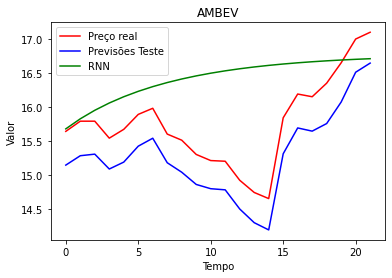

In [176]:
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões Teste')
plt.plot(RNN, color = 'green', label = 'RNN')

plt.title('AMBEV')
plt.ylabel('Valor')
plt.xlabel('Tempo')
plt.legend()
plt.show()